In [1]:
import numpy as np
import qiclib as ql
import matplotlib.pyplot as plt

if ql.packages.qkit_polyfill.QKIT_ENABLED:
    import qkit
    qkit.cfg['user'] = 'Test'
    qkit.cfg['run_id'] = 'test'
    qkit.start()

QKIT configuration initialized -> available as qkit.cfg[...]


INFO:root: ---------- LOGGING STARTED ---------- 
INFO:root:Set instruments dir to /home/rgebauer/phd/projects/qkit/qkit/drivers
INFO:root:qkit.core.s_init.S14_setup_directories : "None" is not a valid path for user_instruments_dir, setting to None
INFO:root:Not checking for updates.


Starting QKIT framework ... -> qkit.core.startup
Loading module ... S10_logging.py
Loading module ... S14_setup_directories.py
Loading module ... S16_available_modules.py
Loading module ... S20_check_for_updates.py
Loading module ... S25_info_service.py
Loading module ... S30_qkit_start.py
Loading module ... S65_load_RI_service.py
Loading module ... S70_load_visa.py
Loading module ... S80_load_file_service.py


INFO:root:loading service: file info database (fid)


Loading module ... S85_init_measurement.py


Loading module ... S98_started.py
Loading module ... S99_init_user.py


In [2]:
from qiclib.code import *

In [3]:
qic = ql.QiController('localhost')

Platform driver version: v0.1.0 +558 (cac06f3d, 29.11.2021 10:33) <dirty>
Establishing gRPC connection to localhost:50058...
Standard Qubit-Platform running on ZCU111 board
QiController firmware built 2021-11-28 20:35:34 (rev. 714)
Firmware with 10 digital unit cells detected.


In [4]:
sample = QiSample(1)
sample[0]["rec_pulse"] = 400e-9      # duration of readout pulse
sample[0]["rec_length"] = 400e-9     # duration of recording
sample[0]["rec_frequency"] = 60e6    # IF frequency for readout pulse
sample[0]["manip_frequency"] = 80e6  # IF frequency for control pulse
sample[0]["pi"] = 160e-9             # pi pulse duration
sample[0]["T1"] = 2e-6               # 1/5 of delay to thermalize qubit

HTML(value="<table style='width:100%'><tr><td> (0/100) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'))

HTML(value="<table style='width:100%'><tr><td> (0/256) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   …

IntProgress(value=0, description='QiCode', layout=Layout(width='95%'), max=256)

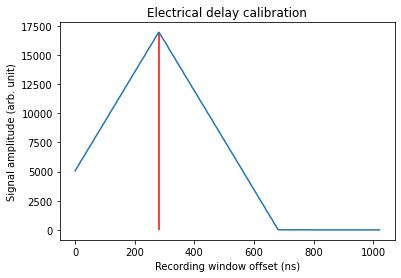

Optimal offset: 280.0 ns


HTML(value="<table style='width:100%'><tr><td> (0/100) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'))

Mirror sideband is 14.5 dB suppressed at recording input


HTML(value="<table style='width:100%'><tr><td> (0/1000) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--  …

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1000)

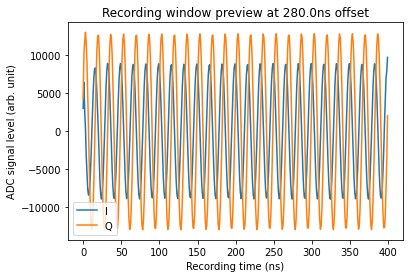

In [5]:
ql.init.calibrate_readout(qic, sample, averages=100)

In [6]:
@QiGate
def Readout(cell):
    PlayReadout(cell, QiPulse(cell["rec_pulse"]))
    Recording(cell, cell["rec_length"], cell["rec_offset"], save_to="result")

@QiGate
def PiPulse(cell):
    Play(cell, QiPulse(cell["pi"]))

@QiGate
def PiHalfPulse(cell):
    Play(cell, QiPulse(cell["pi"] / 2))

In [7]:
with QiJob() as rabi:
    q = QiCells(1)
    length = QiTimeVariable()
    var1 = QiVariable(int, 0)
    var2 = QiVariable(int)
    
    with ForRange(length, 0, 400e-9, 100e-9):
        Play(q[0], QiPulse(length))
        PlayReadout(q[0], QiPulse(length))
        Recording(q[0], q[0]["rec_offset"])
        Wait(q[0], 2)

rabi.print_assembler(sample)
        
rabi.run(qic, sample, averages=2)

Print program for cell index 0
0# Op: TRIGGER, mod0: 0x0, mod1: 0x0, mod2: 0x0, mod3: 0x0

1# Op: REG_IMM, dst: 1, funct3: ADD, rs1: 0, immediate: 0x0 

2# Op: TRIGGER, mod0: 0x0, mod1: 0x1, mod2: 0x0, mod3: 0x0

3# Op: WAIT_IMM, dst: 0, immediate: 0x46

4# Op: LOAD_UPPER_IMM, dst: 2, immediate: 0x1dcd6000

5# Op: REG_IMM, dst: 2, funct3: ADD, rs1: 2, immediate: 0x4fe 

6# Op: WAIT_REG, dst: 2, immediate: 0x0

7# Op: REG_IMM, dst: 2, funct3: ADD, rs1: 0, immediate: 0x64 

8# Op: REG_IMM, dst: 1, funct3: ADD, rs1: 0, immediate: 0x19 

9# Op: BRANCH, funct3: BGE, rs1: 1, rs2: 2, immediate: 0xb

10# Op: TRIGGER, mod0: 0x0, mod1: 0x0, mod2: 0x1, mod3: 0x0

11# Op: TRIG_WAIT_REG, dst: 1, immediate: 0x0

12# Op: TRIGGER, mod0: 0x1, mod1: 0x1, mod2: 0xe, mod3: 0x0

13# Op: TRIG_WAIT_REG, dst: 1, immediate: 0x0

14# Op: TRIGGER, mod0: 0xe, mod1: 0x0, mod2: 0x0, mod3: 0x0

15# Op: LOAD_UPPER_IMM, dst: 3, immediate: 0x1dcd6000

16# Op: REG_IMM, dst: 3, funct3: ADD, rs1: 3, immediate: 0x4fe 

17#

/home/rgebauer/phd/projects/qup_client/qiclib/code/qi_jobs.py:250: UserWarning: Readout pulses without frequency given, using 30 MHz.
  warnings.warn("Readout pulses without frequency given, using 30 MHz.")
/home/rgebauer/phd/projects/qup_client/qiclib/code/qi_jobs.py:210: UserWarning: Manipulation pulses without frequency given, using 90 MHz.
  warnings.warn(


In [8]:
with QiJob() as T1:
    q = QiCells(1)
    length = QiTimeVariable()
    with ForRange(length, 0, 400e-9, 100e-9):
        PiPulse(q[0])
        Wait(q[0], length)
        Readout(q[0])
        Wait(q[0], 2)
        
T1.run(qic, sample)

HTML(value="<table style='width:100%'><tr><td> (0/1) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (e…

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1)

HTML(value="<table style='width:100%'><tr><td> (0/4) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (e…

IntProgress(value=0, description='QiCode', layout=Layout(width='95%'), max=4)

In [9]:
with QiJob() as ramsey:
    q = QiCells(1)
    length = QiTimeVariable()
    with ForRange(length, 0, 100e-9, 24e-9):
        PiHalfPulse(q[0])
        Wait(q[0], length)
        PiHalfPulse(q[0])
        Readout(q[0])
        Wait(q[0], 2)
        
ramsey.run(qic, sample)

HTML(value="<table style='width:100%'><tr><td> (0/1) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (e…

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1)

HTML(value="<table style='width:100%'><tr><td> (0/5) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (e…

IntProgress(value=0, description='QiCode', layout=Layout(width='95%'), max=5)

In [10]:
with QiJob() as spin_echo:
    q = QiCells(1)
    length = QiTimeVariable()
    with ForRange(length, 0, 100e-9, 24e-9):
        PiHalfPulse(q[0])
        Wait(q[0], length)
        PiPulse(q[0])
        Wait(q[0], length)
        PiHalfPulse(q[0])
        Readout(q[0])
        Wait(q[0], 2)
        
spin_echo.run(qic, sample)

HTML(value="<table style='width:100%'><tr><td> (0/1) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (e…

IntProgress(value=0, description='Averages', layout=Layout(width='95%'), max=1)

HTML(value="<table style='width:100%'><tr><td> (0/5) </td><td>&#9992; -?-    </td><td>&#128336;  --:--:--   (e…

IntProgress(value=0, description='QiCode', layout=Layout(width='95%'), max=5)

In [11]:
with QiJob() as nested_loop:
    q = QiCells(1)
    p1_length = QiTimeVariable()
    p2_length = QiTimeVariable()
    #result = QiResult()
    
    with ForRange(p1_length, 0, 52e-9, 4e-9):
        with ForRange(p2_length, 0, 52e-9, 4e-9):
            PlayReadout(q[0], QiPulse(length=p1_length))
            Play(q[0], QiPulse(length=p2_length))
            #Recording(q[0], result)
            Wait(q[0], 0.5)
    

In [12]:
nested_loop.print_assembler()

Print program for cell index 0
0# Op: TRIGGER, mod0: 0x0, mod1: 0x0, mod2: 0x0, mod3: 0x0

1# Op: REG_IMM, dst: 1, funct3: ADD, rs1: 0, immediate: 0x0 

2# Op: REG_IMM, dst: 2, funct3: ADD, rs1: 0, immediate: 0x0 

3# Op: LOAD_UPPER_IMM, dst: 3, immediate: 0x7736000

4# Op: REG_IMM, dst: 3, funct3: ADD, rs1: 3, immediate: 0x93e 

5# Op: WAIT_REG, dst: 3, immediate: 0x0

6# Op: REG_IMM, dst: 2, funct3: ADD, rs1: 0, immediate: 0x1 

7# Op: TRIGGER, mod0: 0x0, mod1: 0x0, mod2: 0x1, mod3: 0x0

8# Op: TRIGGER, mod0: 0x0, mod1: 0x0, mod2: 0xe, mod3: 0x0

9# Op: LOAD_UPPER_IMM, dst: 3, immediate: 0x7736000

10# Op: REG_IMM, dst: 3, funct3: ADD, rs1: 3, immediate: 0x93e 

11# Op: WAIT_REG, dst: 3, immediate: 0x0

12# Op: REG_IMM, dst: 3, funct3: ADD, rs1: 0, immediate: 0xd 

13# Op: REG_IMM, dst: 2, funct3: ADD, rs1: 0, immediate: 0x2 

14# Op: BRANCH, funct3: BGE, rs1: 2, rs2: 3, immediate: 0x9

15# Op: TRIGGER, mod0: 0x0, mod1: 0x0, mod2: 0x1, mod3: 0x0

16# Op: TRIG_WAIT_REG, dst: 2, immedi

In [13]:
nested_loop.run(qic, averages = 1)

In [14]:
with QiJob() as multiple:
    q = QiCells(2)
    length = QiTimeVariable(100e-9)
    
    Play(q[0], QiPulse(length))
    Play(q[1], QiPulse(length))
    Readout(q[1])
    Readout(q[0])
    
    Wait(q[0], 2)
    Wait(q[1], 2)

multiple.print_assembler(sample, 0)
multiple.print_assembler(sample, 1)
multiple.run(qic, sample, averages=10)
    

Print program for cell index 0


ValueError: Cell 1 of the job has unresolved properties but no QiSample object is specified for this cell!

In [ ]:
multiple.print_assembler(0)

Print program for cell index 0
0# Op: TRIGGER, mod0: 0xf, mod1: 0xf, mod2: 0xf, mod3: 0xf

1# Op: REG_IMM, dst: 1, funct3: ADD, rs1: 0, immediate: 0x2

2# Op: TRIGGER, mod0: 0x0, mod1: 0x0, mod2: 0x1, mod3: 0x0

3# Op: WAIT_IMM, dst: 0, immediate: 0xc

4# Op: REG_IMM, dst: 1, funct3: ADD, rs1: 0, immediate: 0x2

5# Op: WAIT_REG, dst: 1, immediate: 0x0

6# Op: LOAD_UPPER_IMM, dst: 2, immediate: 0xee6b000

7# Op: REG_IMM, dst: 2, funct3: ADD, rs1: 2, immediate: 0x27e

8# Op: SYNCH, funct3: START_REG, rs1: 0, rs2: 2, immediate: 0x0



In [ ]:
multiple.print_assembler(1)

Print program for cell index 1
0# Op: TRIGGER, mod0: 0xf, mod1: 0xf, mod2: 0xf, mod3: 0xf

1# Op: WAIT_REG, dst: 1, immediate: 0x0

2# Op: LOAD_UPPER_IMM, dst: 2, immediate: 0xee6b000

3# Op: REG_IMM, dst: 2, funct3: ADD, rs1: 2, immediate: 0x27e

4# Op: SYNCH, funct3: START_REG, rs1: 0, rs2: 2, immediate: 0x0



In [ ]:
with QiJob() as para_test:
    q = para_test.cells
    v_wait = QiTimeVariable(40e-9)
    v_pulse = QiTimeVariable(60e-9)
    
    with Parallel():
        Play(q[0], QiPulse(v_pulse))
    with Parallel():
        Wait(q[0], v_wait)
        PlayReadout(q[0], QiPulse(v_pulse))

    Wait(q[0],2)
    
    Assign(v_pulse, 40e-9)
    Assign(v_wait, 0)
    
    with Parallel():
        Play(q[0], QiPulse(v_pulse))
    with Parallel():
        Wait(q[0], v_wait)
        PlayReadout(q[0], QiPulse(v_pulse))
                    
    Wait(q[0],2)

In [ ]:
para_test.run(qic, sample)

Running program for cell index 0


In [ ]:
del v_wait

In [ ]:
with QiJob() as pingpong:
    q = QiCells(1)
    v_wait = QiTimeVariable()
    Assign(v_wait, 100e-9)
    
    with ForRange(v_wait, 0, 100e-9, 20e-9):    
        with If(v_wait != 0):
            PlayReadout(q[0], QiPulse(length=50e-9))
            Wait(q[0], v_wait)
        with Else():
            with Parallel():
                PlayReadout(q[0], QiPulse(length=50e-9))
            with Parallel():
                Play(q[0], QiPulse(length=50e-9))

        Play(q[0], QiPulse(length=50e-9, amplitude=0.5, shape=ShapeLib.r_sphere))
        Play(q[0], QiPulse(length=50e-9, amplitude=0.5, shape=ShapeLib.l_sphere))

        Wait(q[0], 100e-9 - v_wait)
        PlayReadout(q[0], QiPulse(length=50e-9))
        Wait(q[0], 3)

        
    with ForRange(v_wait, 100e-9, 0, -20e-9):
        PlayReadout(q[0], QiPulse(length=50e-9))
        Wait(q[0], v_wait)

        Play(q[0], QiPulse(length=50e-9, amplitude=0.5, shape=ShapeLib.r_sphere))
        Play(q[0], QiPulse(length=50e-9, amplitude=0.5, shape=ShapeLib.l_sphere))

        with If(v_wait == 100e-9):
            with Parallel():
                PlayReadout(q[0], QiPulse(length=50e-9))
            with Parallel():
                Play(q[0], QiPulse(length=50e-9))
        with Else():
            Wait(q[0], 100e-9 - v_wait)
            PlayReadout(q[0], QiPulse(length=50e-9))
        Wait(q[0], 3)
        
        

In [ ]:
pingpong.print_assembler()

Print program for cell index 0
0# Op: TRIGGER, mod0: 0xf, mod1: 0xf, mod2: 0xf, mod3: 0xf

1# Op: REG_IMM, dst: 1, funct3: ADD, rs1: 0, immediate: 0x19

2# Op: REG_IMM, dst: 1, funct3: ADD, rs1: 0, immediate: 0x0

3# Op: BRANCH, funct3: BEQ, rs1: 1, rs2: 0, immediate: 0x4

4# Op: TRIGGER, mod0: 0x1, mod1: 0x0, mod2: 0x0, mod3: 0x0

5# Op: WAIT_IMM, dst: 0, immediate: 0xc

6# Op: JUMP, immediate: 0x3

7# Op: TRIGGER, mod0: 0x1, mod1: 0x0, mod2: 0x1, mod3: 0x0

8# Op: WAIT_IMM, dst: 0, immediate: 0xc

9# Op: TRIGGER, mod0: 0x0, mod1: 0x0, mod2: 0x2, mod3: 0x0

10# Op: WAIT_IMM, dst: 0, immediate: 0xc

11# Op: TRIGGER, mod0: 0x0, mod1: 0x0, mod2: 0x3, mod3: 0x0

12# Op: WAIT_IMM, dst: 0, immediate: 0xc

13# Op: REG_IMM, dst: 3, funct3: ADD, rs1: 0, immediate: 0x19

14# Op: REGISTER_REGISTER, dst: 2, funct3: ADD_SUB_MUL, rs1: 3, rs2: 1, funct7: SUB

15# Op: WAIT_REG, dst: 2, immediate: 0x0

16# Op: TRIGGER, mod0: 0x1, mod1: 0x0, mod2: 0x0, mod3: 0x0

17# Op: WAIT_IMM, dst: 0, immediate: 0x

/home/rainer/sources/qi_code/qi_code/qi_sequencer.py:417: UserWarning: Calculations inside wait might impede timing
  warnings.warn("Calculations inside wait might impede timing")


In [ ]:
pingpong.run(qic, sample)

Running program for cell index 0
